<a href="https://colab.research.google.com/github/oscarcortez/colaboratory-projects/blob/main/robot_trading_lazy_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# dataframes and queries
import pandas as pd 
# math
import numpy as np 
# draw charts
from matplotlib import pyplot as plt
# web scraping
from bs4 import BeautifulSoup
import requests
import html5lib
from urllib.request import urlopen
#para convertir currency a number
from re import sub
# import companies historial actions values
import yfinance as yf
# datetimes
from datetime import datetime
# clear output
import os
# for delay
import time
# for clear screen output
from IPython.display import clear_output
# for lazy loading - web scrapping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By

In [ ]:
class stock_exchange:
    
    def __init__(self, company_simbol):
        self.company_simbol = company_simbol
        self.period = "7d"
        self.interval = "5m"
        
    def import_base_company(self):
    
        self.df_base_company = yf.download(tickers = f"{self.company_simbol}-USD", period = self.period , interval = self.interval)
    
    def get_html_by_lazy_loading(self):
    
        driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))    
        driver.get('https://coinmarketcap.com/')
        last_height = driver.execute_script("return document.body.scrollHeight")

        while True:
            driver.find_element(By.TAG_NAME,'body').send_keys(Keys.PAGE_DOWN)            
            time.sleep(1)    
            new_height = driver.execute_script("return document.body.scrollHeight")        
            if new_height == last_height:
                break        
            last_height = new_height

        driver.find_element(By.TAG_NAME,'body').send_keys(Keys.END)
        time.sleep(1)
        html = driver.page_source
        driver.quit()
        return html

    def find_convert_price_to_float(self, tr):
        # review price values: 0.0...0XXX 
        company_price = ''
        company_number_price = 0
        price_classnames = ["sc-cadad039-0 clgqXO","sc-cadad039-0 clgqXO fall", "sc-cadad039-0 clgqXO rise"]
        if tr.find('div', class_= price_classnames) is not None and tr.find('div', class_=price_classnames).a.span.get_text() is not None:        
            company_price = tr.find('div', class_= price_classnames).a.span.get_text()
            try:
                company_number_price = float(sub(r'[^\d.]', '', tr.find('div', class_= price_classnames).a.span.get_text()))
            except ValueError:
                company_number_price = 0        

        return company_price, company_number_price
    
    def extract_trend(self):
                
        soup = BeautifulSoup(self.get_html_by_lazy_loading(), 'html.parser')
        table = soup.findAll('table', class_="sc-beb003d5-3 ieTeVa cmc-table")[0]
        trend_classname_meaning = {'icon-Caret-up':'High','icon-Caret-down':'Low'}
        companies = []
        
        for i, tr in enumerate(table.find_all('tr')[1:]):        
            company = {}
            company['name'] = tr.find('p', class_="sc-4984dd93-0 kKpPOn").get_text()
            company['simbol'] = tr.find('p', class_="sc-4984dd93-0 iqdbQL coin-item-symbol").get_text()
            company_price, company_number_price = self.find_convert_price_to_float(tr)
            company['price'] = company_price
            company['number_price'] = company_number_price            
            company['trend'] = trend_classname_meaning [tr.find('span', class_='sc-97d6d2ca-0').span.attrs['class'][0]]
            companies.append(company)

        self.companies = pd.DataFrame(companies)
        self.company, self.current_price, self.current_trend = self.companies.query(f"simbol == '{self.company_simbol}'")[['name', 'number_price', 'trend']].values.flatten().tolist()        
  
    def clean_data(self):
        self.df_base_company_cleaned = self.df_base_company[['Close','Volume']].query("Close != 0 and Volume != 0").drop_duplicates()
        df_base_company_close = self.df_base_company_cleaned['Close']
        Q1 = df_base_company_close.quantile(.25)
        Q3 = df_base_company_close.quantile(.75)
        IIQ = Q3 - Q1
        self.lower_limit = Q1 - 1.5 * IIQ
        self.upper_limit = Q3 + 1.5 * IIQ
        self.df_base_company_cleaned = self.df_base_company_cleaned.query(f'Close >= {self.lower_limit} and Close <= {self.upper_limit}')
  
    def take_decision(self):

        self.mean_company, self.max_company, self.min_company, self.count_company = self.df_base_company_cleaned.describe()[['Close']].T[['mean','max','min','count']].values.flatten().tolist()
        self.decision = 'No Action'
        if self.current_price >= self.mean_company and self.current_trend == 'Low':
            self.decision = 'Sell'
        elif self.current_price < self.mean_company and self.current_trend == 'High':
            self.decision = 'Buy'

    def visualization(self):
    
        today = datetime.now()
        plt.plot()
        plt.plot(self.df_base_company.index, self.df_base_company['Close'])
        self.df_base_company=self.df_base_company.assign(Mean=self.mean_company)
        plt.plot(self.df_base_company.index, self.df_base_company['Mean'])
        plt.title(f'{self.company} Price ($)')
        plt.xlabel('Dates')
        plt.ylabel('Amount ($)')
        plt.rcParams["figure.figsize"] = (12,6)

        print(f'Execution time: {today.strftime("%d/%m/%Y %H:%M:%S")}')
        print(f'Mean price {self.company}: {self.mean_company}')
        print(f'Current price: {self.current_price}')
        print(f'Current Trend: {self.current_trend}')
        print(f'Action: {self.decision}')
        plt.show()

    def automate(self, minutes):

        while(True):
            clear_output()
            self.import_base_company()
            self.extract_trend()
            self.clean_data()
            self.take_decision()
            self.visualization()
            time.sleep(minutes * 60)

se = stock_exchange('BTC')

In [ ]:
se.import_base_company()
se.df_base_company

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-05-17 00:00:00+00:00,27035.470703,27038.613281,27023.728516,27023.728516,27023.728516,0
2023-05-17 00:05:00+00:00,27024.607422,27026.638672,27020.191406,27021.333984,27021.333984,0
2023-05-17 00:10:00+00:00,27018.843750,27052.804688,27018.843750,27052.804688,27052.804688,1676288
2023-05-17 00:15:00+00:00,27052.896484,27052.896484,27010.261719,27010.972656,27010.972656,0
2023-05-17 00:20:00+00:00,27014.726562,27014.726562,27003.210938,27003.210938,27003.210938,0
...,...,...,...,...,...,...
2023-05-22 20:55:00+00:00,26924.753906,26924.753906,26905.283203,26905.283203,26905.283203,31050752
2023-05-23 00:00:00+00:00,26855.960938,26857.056641,26851.968750,26854.099609,26854.099609,0
2023-05-23 00:05:00+00:00,26855.992188,26861.468750,26855.992188,26861.468750,26861.468750,1448960


<AxesSubplot:>

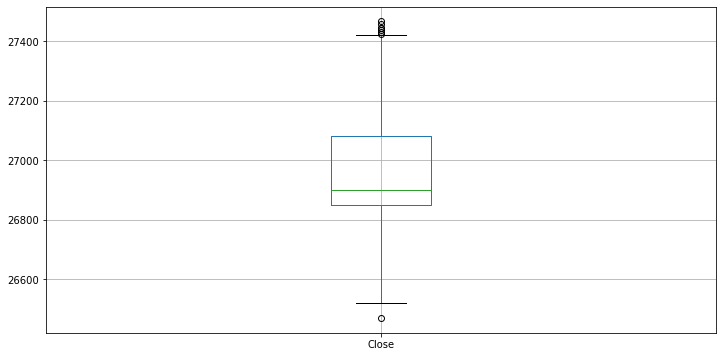

In [ ]:
se.df_base_company.boxplot(['Close'])

In [ ]:
se.extract_trend()

In [ ]:
pd.set_option('display.max_rows', 100)
se.companies

,name,simbol,price,number_price,trend
0,Bitcoin,BTC,"$26,822.36",26822.36000,Low
1,Ethereum,ETH,"$1,816.54",1816.54000,Low
2,Tether,USDT,$1.00,1.00000,High
3,BNB,BNB,$309.51,309.51000,High
4,USD Coin,USDC,$0.9999,0.99990,Low
5,XRP,XRP,$0.4622,0.46220,High
6,Cardano,ADA,$0.3671,0.36710,Low
7,Dogecoin,DOGE,$0.07297,0.07297,Low
8,Polygon,MATIC,$0.872,0.87200,Low
9,Solana,SOL,$19.48,19.48000,Low


In [ ]:
se.clean_data()

<AxesSubplot:>

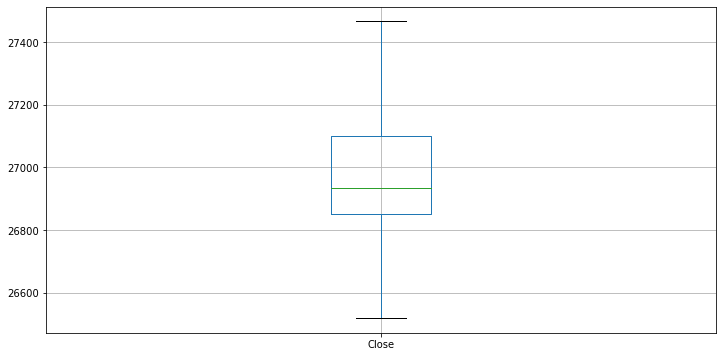

In [ ]:
se.df_base_company_cleaned.boxplot(['Close'])

In [ ]:
se.take_decision()
print(f'Mean {se.company}: {se.mean_company}')
print(f'Decision: {se.decision}')

Mean Bitcoin: 26985.050812007874
Decision: No Action


Execution time: 22/05/2023 19:24:33
Mean price Bitcoin: 26985.050812007874
Current price: 26852.92
Current Trend: Low
Action: No Action


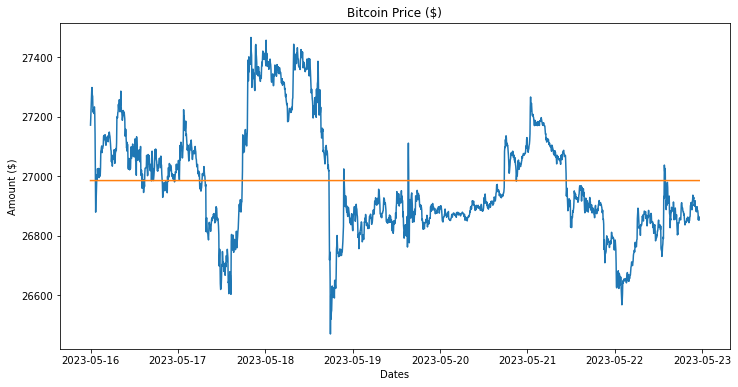

In [ ]:
se.visualization()

In [ ]:
se.automate(minutes = 2)

[*********************100%***********************]  1 of 1 completed


KeyboardInterrupt: 